<h1>Прогнозирование заказов такси<a class="tocSkip"></h1>
   
<h2>Краткое описание<a class="tocSkip"></h2>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
    
<h2>Цель проекта<a class="tocSkip"></h2>
    
Построить модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше `48`.
    
<h2>Краткое описание таблицы<a class="tocSkip"></h2> 
  
Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# для разделения выборки
from sklearn.model_selection import train_test_split

# инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
# импортируем модели
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb  # XGBoost модель
import lightgbm as lgb  # LightGBM модель
import catboost as cb  # CatBoost модель
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer, make_column_transformer

# кодировщики
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler 
)

from statsmodels.tsa.seasonal import seasonal_decompose

from time import time
from tqdm import tqdm

In [2]:
# код ревьюера, провервка версии библиоетки
import sklearn
sklearn.__version__

'0.24.1'

In [3]:
#Константы
RANDOM_STATE = SEED = 42
TEST_SIZE = 0.1

# Функции, используемые в проекте

In [4]:
#Функция для отображения основной информации по датафрейму

def check_df (dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(f'Общая информация по датафрейму {df_name}:')
        # общая информация
        df.info()
        # описательная статистика
        display(df.describe())
        # первые 5 строк
        display(df.head())
        print()
        print(f'В датафрейме {df_name}:')
        print(f'Количество пропущенных значений:\n{df.isna().sum()} \
        \nКоличество явных дубликатов: {df.duplicated().sum()}')
        print()

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

**Загрузка данных**

In [5]:
taxi_data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [6]:
check_df([taxi_data])

Общая информация по датафрейму taxi_data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



В датафрейме taxi_data:
Количество пропущенных значений:
num_orders    0
dtype: int64         
Количество явных дубликатов: 26415



**Ресемплирование**

In [7]:
taxi_final = taxi_data.resample('1H').sum()

**Вывод по разделу**

- Данные представлены за промежуток времени с `марта` по `август` 2018 года
- Пропущенные значения и дубликаты отсутствуют
- Ресемплировали поездки по часам.

## Анализ

In [8]:
taxi_final.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Так как период данных слишком большой, попробуем визуализировать по-разному для лучшего понимая состава датасета**

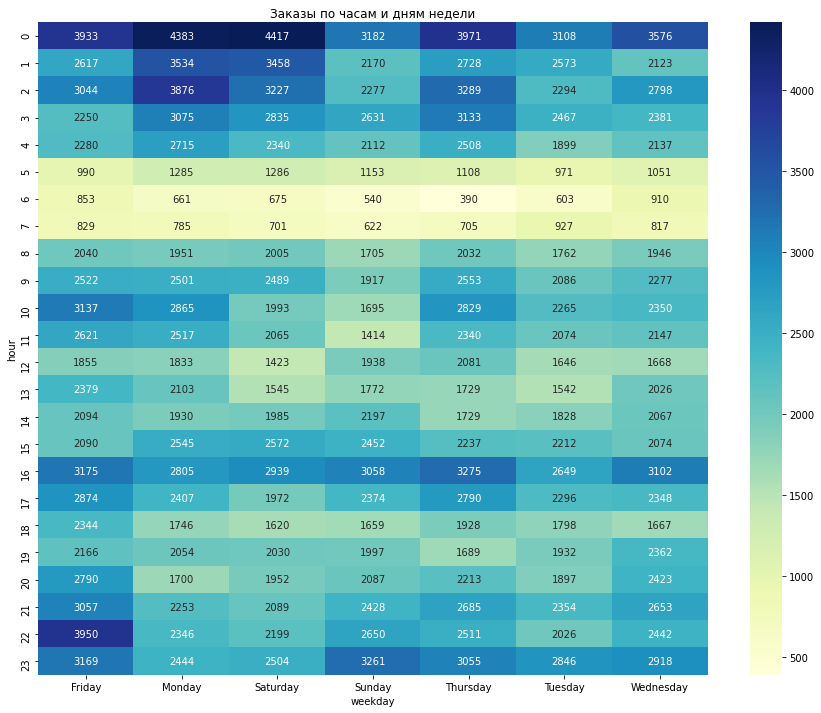

In [9]:
# Создаем колонки с днем недели и часом
taxi_final['hour'] = taxi_final.index.hour
taxi_final['weekday'] = taxi_final.index.day_name()

# Строим тепловую карту
pivot = taxi_final.pivot_table(index='hour', 
                                columns='weekday', 
                                values='num_orders',
                                aggfunc='sum')

plt.figure(figsize=(15, 12))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Заказы по часам и дням недели')
plt.show()

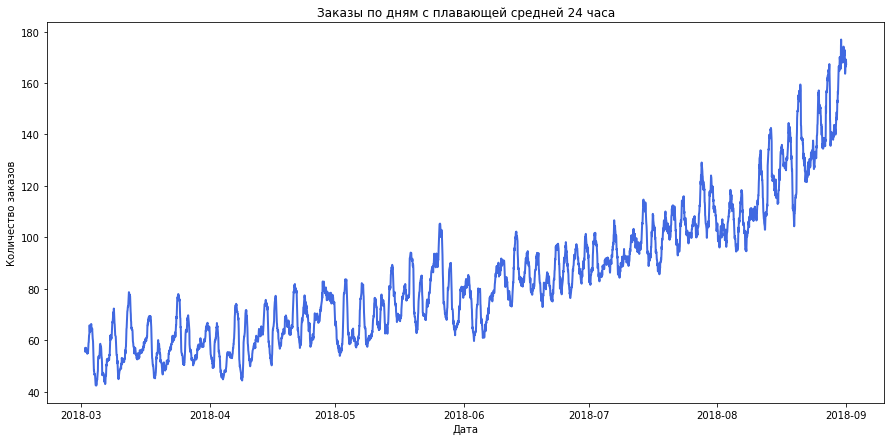

In [10]:
window_size = 24 
taxi_final_smoothed = taxi_final.rolling(window=window_size).mean()

plt.figure(figsize=(15, 7))
plt.plot(taxi_final_smoothed.index, taxi_final_smoothed['num_orders'], 
         linewidth=2, color='royalblue')
plt.title('Заказы по дням с плавающей средней 24 часа')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

In [11]:
decomposed = seasonal_decompose(taxi_final.drop(columns=['weekday', 'hour']))

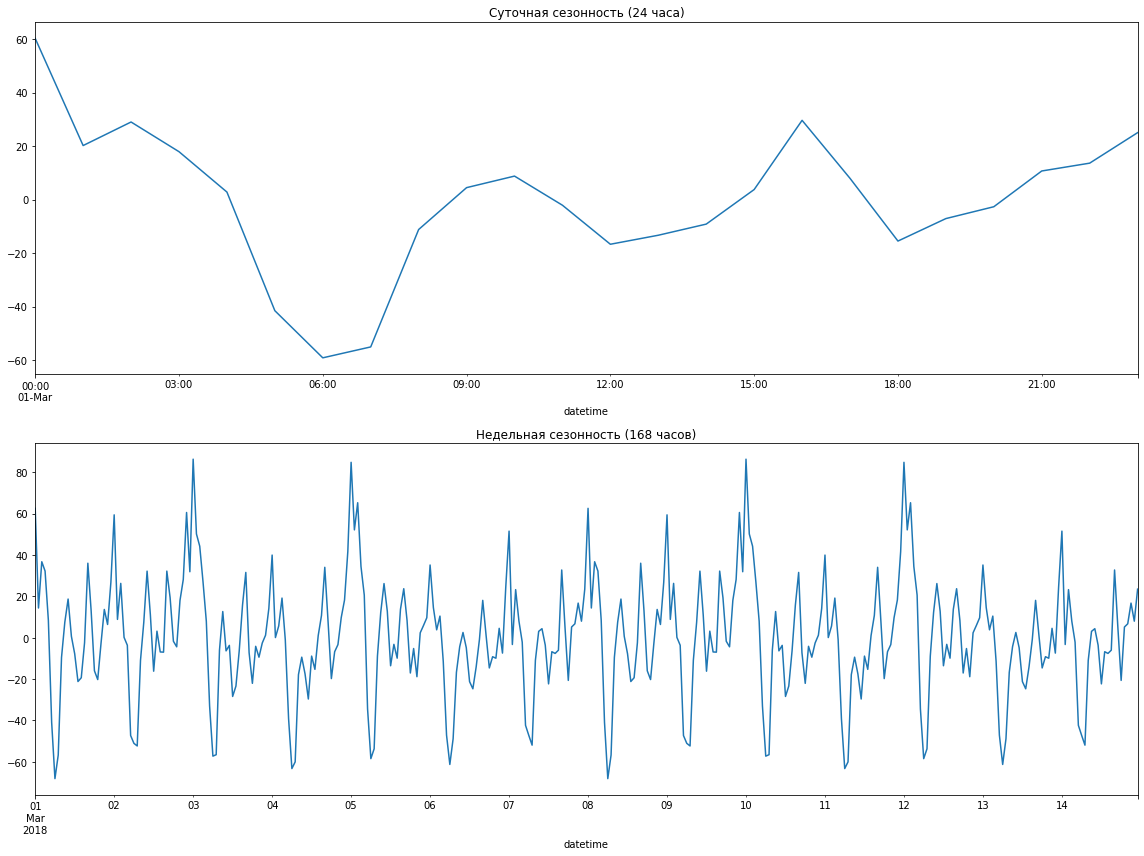

In [12]:
# Декомпозиция с суточным периодом (24 часа)
decomposed_24h = seasonal_decompose(taxi_final.drop(columns=['weekday', 'hour']), period=24)

# Декомпозиция с недельным периодом (24*7 = 168 часов)
decomposed_168h = seasonal_decompose(taxi_final.drop(columns=['weekday', 'hour']), period=168)

# Визуализация результатов
plt.figure(figsize=(16, 12))

# График сезонности за сутки (24 часа)
plt.subplot(2, 1, 1)
decomposed_24h.seasonal[:24].plot()  # Первые 24 часа
plt.title('Суточная сезонность (24 часа)')

# График сезонности за неделю (168 часов)
plt.subplot(2, 1, 2)
decomposed_168h.seasonal[:336].plot()  # Первые 168 часов (неделя)
plt.title('Недельная сезонность (168 часов)')

plt.tight_layout()
plt.show()

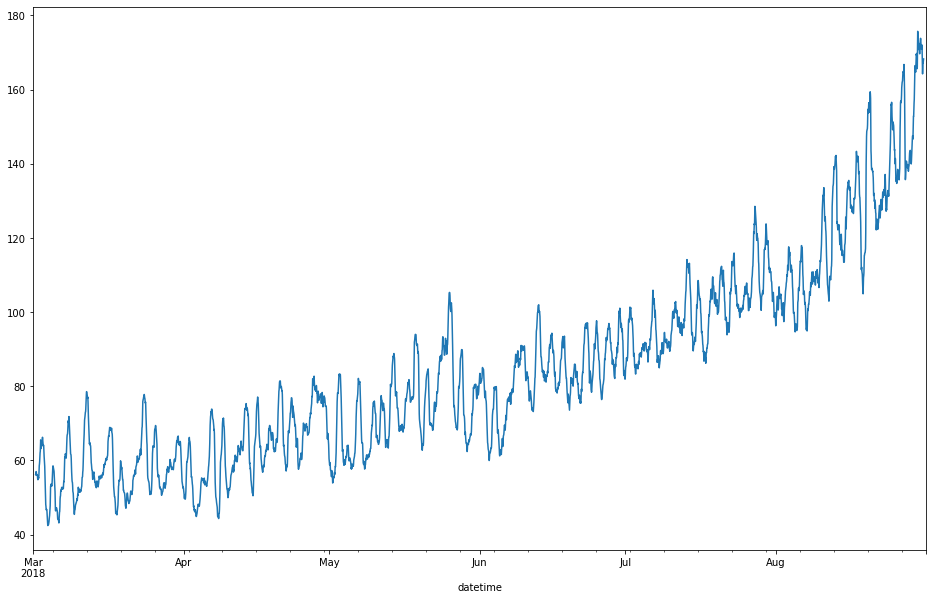

In [13]:
plt.figure(figsize=(16, 10))
decomposed.trend.plot()
plt.show()

- Получилось что в суточном периоде есть закономерность - Заказы постепенно растут ближе к полуночи и снижаются к 6 утра до минимума. Еще один пик заказов около 17:00 - окончание рабочего дня
- В недельный период наблюдаются скачки заказов такси на викэндах (сб-вс) и по понедельникам, когда люди после выходных возможно опаздывают, из-за чего берут такси
- Тренд датасета восходящий, количество заказов увеличивается

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
    <b>v2</b> 👍 </div>

**Вывод по разделу**

- Больше всего заказов 20 августа 2018 года `462` заказа в 02:00
- Обший тренд количества заказов - восходящий, увеличивается со временем - компания развивается и привлекает больше клиентов.
- Больше всего заказов ночью по `Понедельникам и вторникам`

## Обучение

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['weekday'] = data.index.weekday
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(taxi_final, 24, 168)    

In [15]:
taxi_final.sample()

,num_orders,hour,weekday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-04 13:00:00,80,13,2,85.0,80.0,83.0,96.0,104.0,31.0,30.0,...,90.0,61.0,95.0,78.0,108.0,130.0,95.0,79.0,58.0,90.392857


In [16]:
ts = taxi_final['num_orders']

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


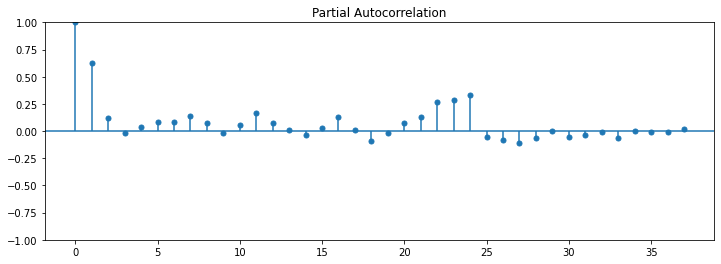

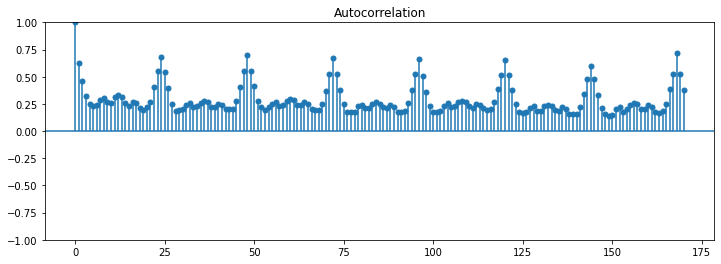

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(ts, alpha=None).set_size_inches(12, 4)
plt.show()

plot_acf(ts, lags=170, alpha=None).set_size_inches(12, 4)
plt.show()

**Пик при автокорреляции на 24 и немного превышающее значение на 168 - сезонность (данные часовые, то суточная/недельная).**

In [18]:
train, test = train_test_split(taxi_final, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()
test = test.dropna()

In [19]:
X_train = train.drop(columns=['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'], axis=1)
y_test = test['num_orders']

In [20]:
# Определение признаков
numeric_features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 
                   'rolling_mean', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 
                   'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24']
categorical_features = ['hour', 'weekday']

In [21]:
# Трансформер
linear_preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    remainder='passthrough'
)

In [22]:
tscv = TimeSeriesSplit(n_splits=5)

In [23]:
# Определение моделей
models = {
    # Линейные модели
    'LinearRegression': {
        'model': Pipeline([
            ('preprocessor', linear_preprocessor),
            ('regressor', LinearRegression())
        ]),
        'params': {}
    },
    
    # Tree-based модели (без трансформера)
    'RandomForest': {
        'model': RandomForestRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(  
            use_label_encoder=False,
            eval_metric='rmse',
            random_state=RANDOM_STATE
        ),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMRegressor(
            random_state=RANDOM_STATE  
        ),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 63]
        }
    },
    'CatBoost': {
        'model': cb.CatBoostRegressor(
            verbose=0,
            random_state=RANDOM_STATE  
        ),
        'params': {
            'iterations': [100, 200],
            'learning_rate': [0.01, 0.1],
            'depth': [4, 6]
        }
    }
}

In [ ]:
# Словарь для хранения лучших моделей и их оценок
best_models = {}
best_scores = {}

# Обучение и подбор гиперпараметров для каждой модели
for name, config in tqdm(models.items(), desc="Обучение моделей"):
    print(f"Обучение модели: {name}")
    start_time = time()

    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
        
    grid.fit(X_train, y_train)
        
    best_models[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_
    
    print(f"Время выполнения: {time() - start_time:.2f} сек")
    print(f"Лучшая оценка RMSE: {-grid.best_score_:.4f}")
    print(f"Лучшие параметры: {grid.best_params_}\n")

# Вывод лучших моделей и их RMSE
print("Лучшие модели и их оценки RMSE:")
for name, score in best_scores.items():
    print(f"{name}: RMSE = {score:.4f}")

Обучение моделей:   0%|          | 0/5 [00:00<?, ?it/s]

Обучение модели: LinearRegression


Обучение моделей:  20%|██        | 1/5 [00:01<00:05,  1.33s/it]

Время выполнения: 1.33 сек
Лучшая оценка RMSE: 24.7178
Лучшие параметры: {}

Обучение модели: RandomForest


Обучение моделей:  40%|████      | 2/5 [03:30<06:10, 123.54s/it]

Время выполнения: 209.08 сек
Лучшая оценка RMSE: 25.2654
Лучшие параметры: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Обучение модели: XGBoost


Обучение моделей:  60%|██████    | 3/5 [34:22<30:25, 912.66s/it]

Время выполнения: 1851.72 сек
Лучшая оценка RMSE: 25.4381
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Обучение модели: LightGBM


**Вывод**

- Подготовили выборку, где в тестовую вошло 10% от исходного датафрейма
- Масштабировали данные при помощи StandardScaler() для линейной модели
- Обучили 5 моделей регрессии: `RandomForest`, `LinearRegression`, `XGBoost`, `LightGBM` и `CatBoost`


- Лучшей моделью стала `LinearRegression`
    
    RMSE лучшей модели `24.7178` и время обучения на кроссвалидации ` 1.76 сек`
    
Далее проверим лучшую модель на тестовой выборке

## Тестирование

Проведем блайнд-тест на тестовой выборке лучшей модели

In [ ]:
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
test_pred = best_model.predict(X_test)

In [ ]:
print('Метрика RMSE на тестовой выборке:', np.sqrt(mean_squared_error(y_test, test_pred)).round(2))

In [ ]:
print('Лучшая модель:', best_model_name)

In [ ]:
# 1. Dummy
dummy_pred = [y_train.mean()] * len(y_test)
dummy_rmse = np.sqrt(mean_squared_error(y_test, dummy_pred))

# 2. берем лаги 24
smart_pred = X_test['lag_24'].values
smart_rmse = np.sqrt(mean_squared_error(y_test, smart_pred))

# Сравнение результатов
print(f"Dummy (среднее) RMSE: {dummy_rmse:.1f}")
print(f"Smart (lag_24) RMSE: {smart_rmse:.1f}")
print('Метрика RMSE на тестовой выборке:', np.sqrt(mean_squared_error(y_test, test_pred)).round(2))

**Вывод**

1. В проекте изучили исторические данные о заказах такси в аэропортах. 
2. Спрогнозировали количество заказов такси на следующий час.
        
3. В подготовке данных провели ресемплирование исходного датасета в `часовой` интервал.
        
        
4. Провели анализ сезонности и трендов:
- Больше всего заказов 20 августа 2018 года 462 заказа в 02:00
- Обший тренд количества заказов - восходящий, увеличивается со временем - компания развивается и привлекает больше клиентов.
- Больше всего заказов ночью по Понедельникам и вторникам, а также в конце викэнда с СБ-ВС.
        
5. Подготовили данные для обучения моделей:
- Убрали лишние признаки и добавили новые признаки `hour` час заказа и `weekday` день недели (которые хорошо показывают сезонность)
- Собрали пайплайн из 5 моделей (1 линейной регрессии и 4 деревья)
- Для модели линейной регрессии применили кодировщики данных - для количественных  StandardScaler() и для категориальных числовых OneHotEncoder()
- Обучили модели на кросс-валидации с параметром cv=TimeSeriesSplit для временных рядов, чтобы не перемешивались выборки и валидационная не оказалась до обучающей.
- По итогам обучения выбрали лучшую модель `LinearRegression` по метрике RMSE, к тому же имеет самое быстрое время обучения

6. Тестирование модели
- На тестовой выборке лучшая модель показала `RMSE = 40.96`
- Проверили модель на адекватность, сравнили с результатами:

Простейший бейзлайн (dummy) - это среднее RMSE по временному ряду равен  `84.0`
Лаг 24 (сутки, 24 часа) - RMSE `57.2`